In [75]:
# Import necessary libraries
import pandas as pd
import numpy as np
import db_utils, sqlalchemy
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
from scipy.stats import fisher_exact
from scipy import stats
import math
import os
import gzip
import re
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import math
import time
from collections import Counter
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
global_fontsize = 14
figsize = (3,3)
legend_fontsize = 8
#bbox_to_anchor =(1.0, 1.0)
import requests
save_path= '/Users/johgeist/Documents/AG_Luck/3did_project/revisions/revision_figures/'

In [2]:
# Function to count rows in a group
def count_rows(group):
    return group.shape[0]

# Function to retrieve domain residues from Chain1/2Iface columns derived from 3did
def retrieve_domain_residue_nos(string):
    resi_nos = set()
    for i in string.split(','):
        pre_resi = i.split(':')[1]
        resi = ''
        for l in pre_resi:
            if l in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '-']:
                resi += l
        resi_nos.add(int(resi))
    return resi_nos

# Function to retrieve domain boundaries given for each CATH domain in each PDB structure
# (derived from the CATH database)

def retrieve_domain_boundaries(string):
    if pd.isna(string):
        domain_bound = np.NaN
    else:
        domain_bounds = []
        for i in string.split(','):
            domain_bound_t = i.split(':')[0]
            domain_bounds.append(domain_bound_t)
        domain_bound = ', '.join(domain_bounds)
    return domain_bound

# Function to check whether CATH domain and Pfam domain overlap for a given PDB ID and chain
def check_range(row, col1, col2, col3):
    if pd.isna(row[col1]):
        return np.NaN
    else:
        n_matches = 0
        for interval in row[col1].split(','):
            pre_range = interval.split('-')
            if len(pre_range) > 2:
                cath_range = pre_range[1:]
            else:
                cath_range = pre_range
            cath_lower = int(cath_range[0])
            cath_upper = int(cath_range[1])
            if any(cath_lower <= elem <= cath_upper for elem in row[col2]):
                n_matches += 1
        if n_matches > 0:
            return row[col3]
        else:
            return 'No match'

# Function to count rows in a group
def count_unique(x):
    return x.nunique()

# Define function to modify ticks and lables of the plots
def modify_ticks_and_labels(ax,x_major_multiple=None,x_minor_multiple=None,
                            y_major_multiple=None,y_minor_multiple=None,
                            fontsize=None):
    if x_major_multiple is not None:
        ax.tick_params(axis='x', which='both')
        ax.xaxis.set_major_locator(MultipleLocator(x_major_multiple))
        ax.xaxis.set_minor_locator(MultipleLocator(x_minor_multiple))
        plt.setp(ax.xaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.xaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.xaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.xaxis.get_minorticklines(), 'markeredgewidth', 2)
    if y_major_multiple is not None:
        ax.tick_params(axis='y', which='both')
        ax.yaxis.set_major_locator(MultipleLocator(y_major_multiple))
        ax.yaxis.set_minor_locator(MultipleLocator(y_minor_multiple))
        plt.setp(ax.yaxis.get_majorticklines(), 'markersize', 5)
        plt.setp(ax.yaxis.get_majorticklines(), 'markeredgewidth', 2)
        plt.setp(ax.yaxis.get_minorticklines(), 'markersize', 3.5)
        plt.setp(ax.yaxis.get_minorticklines(), 'markeredgewidth', 2)
    if fontsize is not None:
        plt.tick_params(axis= 'both', labelsize= fontsize, bottom= False)
    else:
        global global_fontsize
        plt.tick_params(axis= 'both', labelsize= global_fontsize, bottom= False)

In [3]:
# Connect to the MySQL database and read the preprocessed 3did into a DataFrame
eng = sqlalchemy.create_engine('mysql://', creator= db_utils.get_connection)
query= pd.read_sql_query('''select * from chopyan_db.3did_agg_DDI_PDB as df''', con= eng)
DDI_CS = pd.DataFrame(query)
DDI_CS

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,DomainStart2,DomainEnd2,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain
0,PF00001_PF00001,1gzm,A,PF00001,7tm_1,54,306,B,PF00001,7tm_1,54,306,26.18,7.82923,"E:196,E:196,E:196,E:196,E:197,N:199,E:201,E:20...","F:228,K:231,E:232,A:233,E:232,F:228,V:227,F:22...",1
1,PF00001_PF00001,1hzx,B,PF00001,7tm_1,54,246,B,PF00001,7tm_1,224,306,42.49,7.03413,"I:54,I:54,I:54,N:55,N:55,N:55,T:58,L:72,L:72,L...","V:300,P:303,V:304,A:299,V:300,P:303,Y:306,V:25...",0
2,PF00001_PF00001,1l9h,B,PF00001,7tm_1,54,246,B,PF00001,7tm_1,224,306,40.17,9.39410,"I:54,I:54,N:55,N:55,N:55,T:58,L:72,L:72,L:72,L...","V:300,P:303,A:299,V:300,P:303,Y:306,V:250,M:25...",0
3,PF00001_PF00001,2j4y,A,PF00001,7tm_1,54,306,B,PF00001,7tm_1,54,306,26.85,6.86878,"N:199,E:201,E:201,E:201,S:202,S:202,I:205,V:20...","Q:236,F:228,K:231,E:232,F:228,E:232,F:228,F:22...",1
4,PF00001_PF00001,2vt4,C,PF00001,7tm_1,58,343,D,PF00001,7tm_1,58,343,20.02,6.36751,"L:152,V:160,T:164,T:164,A:167,I:168,I:168,A:17...","F:315,A:206,A:206,A:210,W:181,A:210,I:214,W:18...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235443,PF18841_PF17433,1wmr,A,PF18841,B_solenoid_dext,321,354,A,PF17433,Glyco_hydro_49N,19,184,9.52,4.52235,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235444,PF18841_PF17433,1x0c,B,PF18841,B_solenoid_dext,321,354,B,PF17433,Glyco_hydro_49N,19,184,9.52,4.45403,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235445,PF18841_PF17433,2z8g,A,PF18841,B_solenoid_dext,321,354,A,PF17433,Glyco_hydro_49N,19,184,9.24,4.49346,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0
235446,PF18841_PF17433,3wwg,C,PF18841,B_solenoid_dext,321,354,C,PF17433,Glyco_hydro_49N,19,184,9.24,4.61412,"D:341,D:341,D:341,K:343,K:343,V:345,V:345,V:34...","R:153,S:182,P:183,S:101,S:182,Q:97,W:99,L:178,...",0


In [4]:
DDI_CS['PDB_ID']= DDI_CS['PDB_ID'].str.upper()

In [5]:
# Add another column counting residue-residue contactcs of an interface,
# check whether the # ofcontacts are the same for both domains
contacts1 = []
for i in DDI_CS['Chain1Iface']:
    contacts1.append(len(i.split(',')))
DDI_CS['contacts1'] = contacts1
contacts2 = []
for i in DDI_CS['Chain2Iface']:
    contacts2.append(len(i.split(',')))
DDI_CS['contacts2'] = contacts2
DDI_CS[(DDI_CS['contacts1'] != DDI_CS['contacts2'])]

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,DomainStart2,DomainEnd2,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,contacts2


In [6]:
DDI_CS = DDI_CS.drop(columns= ['contacts2'])

In [7]:
# Merge DDI_CS with additional protein information
df_protein_info = pd.read_csv('/Users/johgeist/Downloads/DDI_type_structure_level_interchain_homo_protein_whole_3did.csv', index_col=0)
df_protein_info= df_protein_info.drop(columns=['IsInterchain', 'Chain1', 'Chain2'])
DDI_CS= pd.merge(DDI_CS, df_protein_info, on=['DDI_type', 'PDB_ID'])

In [8]:
# Drop rows that relate to intrachain or homodimeric interfaces
DDI_inter= DDI_CS.drop(index= DDI_CS[DDI_CS['isInterchain'] == 0].index)
DDI_inter_hetero = DDI_inter.drop(index= DDI_inter[DDI_inter['HomoProtein'] == 1].index)

In [9]:
#DDI_inter_hetero.to_csv('/Users/johgeist/Downloads/3did_project_dataframes_new/3did_metrics_inter_hetero_subset_structure_level.csv', index=False)

In [10]:
# Select one interface per DDI type as well as its metrics based on the highest 3did score
df_index_max_Score = DDI_inter_hetero.groupby('DDI_type').agg({'Score': 'idxmax'})
DDI_inter_hetero_grouped_max_Score = DDI_inter_hetero[DDI_inter_hetero.index.isin(df_index_max_Score.Score.tolist())]

In [11]:
DDI_inter_hetero_grouped_max_Score

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,HomoDDI,UniProt1,UniProt2,HomoProtein
72,PF00001_PF00048,5UIW,A,PF00001,7tm_1,47,297,B,PF00048,IL8,...,13.26,5.101720,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",1,51,0,"P51681,P00268",P13501,0
82,PF00001_PF00085,6H7O,B,PF00001,7tm_1,58,343,F,PF00085,Thioredoxin,...,1.57,1.963520,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",1,7,0,P07700,P0AA25,0
84,PF00001_PF00087,6WJC,A,PF00001,7tm_1,42,418,C,PF00087,Toxin_TOLIP,...,15.76,5.828060,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",1,44,0,"P11229,D9IEF7",Q8QGR0,0
85,PF00001_PF00322,5GLH,A,PF00001,7tm_1,107,387,B,PF00322,Endothelin,...,31.19,7.365980,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",1,78,0,"P00720,P24530",P05305,0
92,PF00001_PF00339,6TKO,A,PF00001,7tm_1,58,343,B,PF00339,Arrestin_N,...,18.24,5.657100,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",1,38,0,P07700,P49407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235247,PF18782_PF00559,6NIL,A,PF18782,NAD2,193,372,C,PF00559,Vif,...,7.74,3.639300,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",1,23,0,Q8IUX4,P12504,0
235281,PF18784_PF00071,3NBZ,D,PF18784,CRM1_repeat_2,405,472,F,PF00071,Ras,...,8.76,4.306780,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",1,25,0,Q6P5F9,P62826,0
235371,PF18801_PF00072,3Q15,A,PF18801,RapH_N,4,65,C,PF00072,Response_reg,...,10.48,4.961570,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",1,22,0,Q59HN8,P06628,0
235372,PF18806_PF00071,2X19,B,PF18806,Importin_rep_3,826,900,A,PF00071,Ras,...,0.05,0.237612,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",1,7,0,O94829,P32835,0


In [12]:
# Check whether there are NaN values for the UniProt IDs (from the protein information df)
DDI_inter_hetero_grouped_max_Score[(DDI_inter_hetero_grouped_max_Score['UniProt1']== 'No UniProt') & (DDI_inter_hetero_grouped_max_Score['UniProt2']== 'No UniProt')]

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,Score,Zscore,Chain1Iface,Chain2Iface,isInterchain,contacts1,HomoDDI,UniProt1,UniProt2,HomoProtein


In [13]:
# Keep only those columns that are necessary for further analysis, DDI_type is the unique idendifier for each DDI
# PDB ID of the structure with the highest 3did score is needed later for merging with ProtCID data
DDI_inter_hetero_grouped_max_Score = DDI_inter_hetero_grouped_max_Score.filter(['DDI_type', 'Score', 'Zscore',
'contacts1', 'PDB_ID', 'Chain1Iface', 'Chain2Iface', 'Chain_ID1', 'Chain_ID2'])

In [14]:
DDI_inter_hetero_grouped_max_Score

,DDI_type,Score,Zscore,contacts1,PDB_ID,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2
72,PF00001_PF00048,13.26,5.101720,51,5UIW,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",A,B
82,PF00001_PF00085,1.57,1.963520,7,6H7O,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",B,F
84,PF00001_PF00087,15.76,5.828060,44,6WJC,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",A,C
85,PF00001_PF00322,31.19,7.365980,78,5GLH,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",A,B
92,PF00001_PF00339,18.24,5.657100,38,6TKO,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",A,B
...,...,...,...,...,...,...,...,...,...
235247,PF18782_PF00559,7.74,3.639300,23,6NIL,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",A,C
235281,PF18784_PF00071,8.76,4.306780,25,3NBZ,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",D,F
235371,PF18801_PF00072,10.48,4.961570,22,3Q15,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",A,C
235372,PF18806_PF00071,0.05,0.237612,7,2X19,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",B,A


In [15]:
DDI_inter_hetero_grouped_max_Score.rename({'PDB_ID': 'PDB_ID_max'}, inplace=True, axis=1)

In [16]:
# DDI_merged combines DDI_inter_hetero_grouped_max_Score with additional data from DDI_CS, that can only be inferred 
# from there (# inter-/ intrachain structures etc.) or aid further annoattaion of the DDI
DDI_merged = pd.merge(DDI_CS.groupby('DDI_type').agg({'DomainID1': 'first','DomainID2': 'first',
                                                      'DomainName1': 'first','DomainName2': 'first',
                                                      'PDB_ID': count_rows,
                                                      'isInterchain': sum}).reset_index(),
                                                          DDI_inter_hetero_grouped_max_Score,
                                                        on='DDI_type', how= 'inner')

In [17]:
DDI_merged.rename({'PDB_ID': 'Num_structures', 'isInterchain': 'Num_interchain_structures',
                   'HomoProtein': 'Num_homo_protein_structures', 'HomoDDI': 'Homo_DDI'}, inplace=True, axis=1)
DDI_merged['Interchain_fraction'] = DDI_merged['Num_interchain_structures']/DDI_merged['Num_structures']
DDI_merged['Num_intrachain_structures']= DDI_merged['Num_structures']-DDI_merged['Num_interchain_structures']

In [18]:
DDI_merged

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Num_structures,Num_interchain_structures,Score,Zscore,contacts1,PDB_ID_max,Chain1Iface,Chain2Iface,Chain_ID1,Chain_ID2,Interchain_fraction,Num_intrachain_structures
0,PF00001_PF00048,PF00001,PF00048,7tm_1,IL8,8,8,13.26,5.101720,51,5UIW,"Y:89,Q:170,Q:170,K:171,K:171,E:172,E:172,E:172...","Q:8,F:28,Y:29,E:26,F:28,Q:8,S:9,F:28,S:31,Q:48...",A,B,1.000000,0
1,PF00001_PF00085,PF00001,PF00085,7tm_1,Thioredoxin,7,6,1.57,1.963520,7,6H7O,"V:103,V:103,R:104,R:104,R:104,R:104,R:104","G:51,K:52,D:47,E:48,Y:49,Q:50,G:51",B,F,0.857143,1
2,PF00001_PF00087,PF00001,PF00087,7tm_1,Toxin_TOLIP,1,1,15.76,5.828060,44,6WJC,"Y:82,W:164,W:164,L:167,L:167,V:168,V:168,V:168...","R:34,I:9,W:10,W:10,F:11,I:9,W:10,F:11,P:12,R:4...",A,C,1.000000,0
3,PF00001_PF00322,PF00001,PF00322,7tm_1,Endothelin,4,4,31.19,7.365980,78,5GLH,"I:157,N:158,N:158,N:158,K:161,K:161,K:161,K:16...","I:20,I:19,I:20,W:21,C:15,H:16,L:17,D:18,I:19,H...",A,B,1.000000,0
4,PF00001_PF00339,PF00001,PF00339,7tm_1,Arrestin_N,6,3,18.24,5.657100,38,6TKO,"R:71,Q:73,T:74,L:75,L:75,T:76,N:77,I:80,R:139,...","D:67,T:136,T:136,E:66,T:136,E:66,E:66,V:70,E:6...",A,B,0.500000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,PF18782_PF00559,PF18782,PF00559,NAD2,Vif,1,1,7.74,3.639300,23,6NIL,"R:252,L:255,S:256,S:256,C:259,D:260,D:260,D:26...","P:49,W:70,H:43,W:70,Q:83,R:15,N:19,K:22,Q:83,R...",A,C,1.000000,0
5720,PF18784_PF00071,PF18784,PF00071,CRM1_repeat_2,Ras,34,34,8.76,4.306780,25,3NBZ,"E:429,L:431,L:431,L:431,V:433,E:434,D:436,D:43...","N:156,S:153,N:154,Y:155,S:153,R:29,K:37,K:152,...",D,F,1.000000,0
5721,PF18801_PF00072,PF18801,PF00072,RapH_N,Response_reg,1,1,10.48,4.961570,22,3Q15,"E:45,D:46,Q:47,Q:47,Q:47,Q:47,D:48,L:50,L:50,L...","Y:84,Y:84,Q:12,K:56,A:83,Y:84,Q:12,A:83,Y:84,K...",A,C,1.000000,0
5722,PF18806_PF00071,PF18806,PF00071,Importin_rep_3,Ras,1,1,0.05,0.237612,7,2X19,"P:829,E:830,E:830,E:830,K:835,S:880,S:880","Y:41,K:40,Y:41,I:42,T:95,S:96,I:98",B,A,1.000000,0


In [19]:
# Read in manual curation dataset as a DataFrame and merge with the original 3did DataFrame (DDI_CS) to get the
# respective 3did score for all interfaces 
# select the rows relating to the structure with the interface with the highest 3did score (same as before)
# for a Pfam-Pfam combination
df_mc = pd.read_csv('/Users/johgeist/Downloads/DDI_curation table_wihtout_homo_protein_structures_4.csv')
df_mc = df_mc[~df_mc['DDI_type'].str.contains('curation')]
df_mc['PDB_ID'] = df_mc['PDB_ID'].str.upper()

In [20]:
df_Score = pd.merge(DDI_CS, df_mc, on= ['DDI_type', 'PDB_ID'], how = 'inner')
df_Score

,DDI_type,PDB_ID,Chain_ID1,DomainID1,DomainName1,DomainStart1,DomainEnd1,Chain_ID2,DomainID2,DomainName2,...,ProtCID_cluster_approved,Motif_binding_domain_present,Motif_binding_domain,DMI_overlap_checked,DMI_overlap_identified,DDI_approved,Curator,Comments,non-approved category,Unnamed: 19
0,PF00004_PF10584,6EPF,I,PF00004,AAA,222,355,C,PF10584,Proteasome_A_N,...,1.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",1 out of 1 supporting CS showed an interchain ...,HMM (at least one Pfam has unfolded structure),linear stretch within domain
1,PF00009_PF01873,2D74,A,PF00009,GTP_EFTU,9,201,B,PF01873,eIF-5_eIF-2B,...,0.0,0.0,NaN,NaN,NaN,1.0,JG,11 out of 11 supporting CS showed interchain i...,NaN,NaN
2,PF00010_PF02344,1NKP,B,PF00010,HLH,203,254,D,PF02344,Myc-LZ,...,0.0,0.0,NaN,NaN,NaN,0.0,JG,Second structure checked for PF00010_PF02344. ...,NaN,NaN
3,PF00010_PF02344,6G6L,B,PF00010,HLH,214,254,C,PF02344,Myc-LZ,...,0.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",2 out of 6 supporting structures in 3did showe...,crystal contact,NaN
4,PF00019_PF00041,4UI2,B,PF00019,TGF_beta,294,395,A,PF00041,fn3,...,NaN,0.0,NaN,NaN,NaN,0.0,JG,Only 1 supporting CS was present for the DDI t...,crystal contact,study describes crystal contact interface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,PF17292_PF08644,4KHB,H,PF17292,POB3_N,5,97,G,PF08644,SPT16,...,1.0,0.0,NaN,NaN,NaN,0.0,"JG, KL",3 out of 3 supporting CS displayed interchain ...,contact is minimal,NaN
91,PF17292_PF08644,6UPK,H,PF17292,POB3_N,5,99,G,PF08644,SPT16,...,1.0,0.0,NaN,NaN,NaN,0.0,JG,Second structure checked for PF17292_PF08644. ...,NaN,NaN
92,PF17820_PF16523,3L4F,D,PF17820,PDZ_6,701,755,A,PF16523,betaPIX_CC,...,NaN,0.0,NaN,NaN,NaN,0.0,"JG, JL",Only one structure supporting the DDI type (Sc...,HMM (at least one Pfam has unfolded structure),motif is C-terminally included in the Pfam match
93,PF17838_PF00071,3KZ1,B,PF17838,PH_16,950,1079,E,PF00071,Ras,...,0.0,0.0,NaN,NaN,NaN,1.0,JG,9 out of 9 supporting CS displayed interchain ...,NaN,NaN


In [21]:
df_Score_index = df_Score.groupby('DDI_type').agg({'Score': 'idxmax'})
df_Score_max = df_Score[df_Score.index.isin(df_Score_index.Score.tolist())]

In [22]:
df_Score_max = df_Score_max.filter(['DDI_type', 'Score', 'PDB_ID', 'DDI_approved'])
df_Score_max

,DDI_type,Score,PDB_ID,DDI_approved
0,PF00004_PF10584,3.28,6EPF,0.0
1,PF00009_PF01873,9.54,2D74,1.0
3,PF00010_PF02344,3.30,6G6L,0.0
4,PF00019_PF00041,4.56,4UI2,0.0
5,PF00023_PF07686,1.25,4NIK,0.0
...,...,...,...,...
88,PF16004_PF00400,9.03,6ID0,0.0
90,PF17292_PF08644,2.26,4KHB,0.0
92,PF17820_PF16523,3.24,3L4F,0.0
93,PF17838_PF00071,14.92,3KZ1,1.0


In [23]:
# Derive single columns for Pfam1 and Pfam2, select only those columns necessary for further analysis
df_Score_max['DomainID1']= df_Score_max['DDI_type'].str.split('_').str[0]
df_Score_max['DomainID2']= df_Score_max['DDI_type'].str.split('_').str[1]

In [39]:
df_Score_max_filt = df_Score_max[['DDI_type', 'DomainID1', 'DomainID2']].set_index('DDI_type')

In [40]:
df_Score_max_filt

,DomainID1,DomainID2
DDI_type,,
PF00004_PF10584,PF00004,PF10584
PF00009_PF01873,PF00009,PF01873
PF00010_PF02344,PF00010,PF02344
PF00019_PF00041,PF00019,PF00041
PF00023_PF07686,PF00023,PF07686
...,...,...
PF16004_PF00400,PF16004,PF00400
PF17292_PF08644,PF17292,PF08644
PF17820_PF16523,PF17820,PF16523


In [44]:
# Concatenate Pfams from both columns into a single Series
interaction_series = pd.concat([df_Score_max_filt['DomainID1'], df_Score_max_filt['DomainID2']])

# Get unique Pfams
unique_identifiers = interaction_series.unique()

# Count occurrences of each unique identifier
partner_counts_mc = interaction_series.value_counts().reset_index()

# Rename columns
partner_counts_mc.columns = ['DomainID', '# interacting domains']

partner_counts_mc

,DomainID,# interacting domains
0,PF07686,4
1,PF00071,3
2,PF00412,2
3,PF08644,2
4,PF00023,2
...,...,...
144,PF07724,1
145,PF07741,1
146,PF09291,1
147,PF09781,1


In [49]:
partner_counts_mc[partner_counts_mc['# interacting domains']>1]

,DomainID,# interacting domains
0,PF07686,4
1,PF00071,3
2,PF00412,2
3,PF08644,2
4,PF00023,2
5,PF00041,2
6,PF00595,2
7,PF00400,2


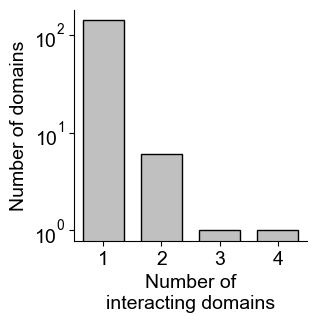

In [76]:
# Plot number of interacting domains per Pfam domain in the maunal curation set

data_y = [len(partner_counts_mc[partner_counts_mc['# interacting domains']== i]) for i in [1,2,3,4]]

fig, axes = plt.subplots(figsize=figsize)
sns.barplot(x= [1,2,3,4], y= data_y, color= 'silver', edgecolor= 'black', linewidth= 1, width=0.7)
axes.set_ylabel('Number of domains', fontsize= global_fontsize)
axes.set_xlabel('Number of\ninteracting domains', fontsize= global_fontsize)
plt.xticks(fontname="Arial", fontsize= global_fontsize)
plt.yticks(fontname="Arial", fontsize= global_fontsize)
plt.yscale('log')
axes.minorticks_off()
#plt.savefig(f'{save_path}no_interacting_domains_distribution_plot_mc.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [25]:
# Read in DDI subset that matchces the intercahin and hetero-protein criteria 
# (already prepared for another analysis)
# Select and filter the necessary column for the analysis
subset_3did = pd.read_csv('/Users/johgeist/Documents/AG_Luck/3did_project/3did_project_dataframes_new/3did_Interactome_ProtCID_metrics_inter_hetero_subset_without_synthetic_constructs.csv')

In [26]:
subset_3did

,DDI_type,DomainID1,DomainID2,DomainName1,DomainName2,Num_structures,Num_interchain_structures,Score,Zscore,contacts1,PDB_ID_max,Interchain_fraction,Num_intrachain_structures,HuRIzscore,BioPlexzscore,Num crystal forms,Min seq identity,Num of proteins,Num clusters
0,PF00001_PF00048,PF00001,PF00048,7tm_1,IL8,8,8,13.26,5.101720,51,5UIW,1.000000,0,8.015862,-2.337582,5.0,18.0,4.0,1.0
1,PF00001_PF00085,PF00001,PF00085,7tm_1,Thioredoxin,7,6,1.57,1.963520,7,6H7O,0.857143,1,-0.455672,-1.268307,2.0,95.0,2.0,4.0
2,PF00001_PF00087,PF00001,PF00087,7tm_1,Toxin_TOLIP,1,1,15.76,5.828060,44,6WJC,1.000000,0,-0.077693,NaN,1.0,100.0,1.0,0.0
3,PF00001_PF00322,PF00001,PF00322,7tm_1,Endothelin,4,4,31.19,7.365980,78,5GLH,1.000000,0,10.129397,-0.495000,3.0,57.0,3.0,1.0
4,PF00001_PF00339,PF00001,PF00339,7tm_1,Arrestin_N,6,3,18.24,5.657100,38,6TKO,0.500000,3,12.478734,1.637844,5.0,18.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5265,PF18782_PF00559,PF18782,PF00559,NAD2,Vif,1,1,7.74,3.639300,23,6NIL,1.000000,0,NaN,NaN,1.0,100.0,1.0,0.0
5266,PF18784_PF00071,PF18784,PF00071,CRM1_repeat_2,Ras,34,34,8.76,4.306780,25,3NBZ,1.000000,0,-0.309397,-0.216169,10.0,50.0,9.0,1.0
5267,PF18801_PF00072,PF18801,PF00072,RapH_N,Response_reg,1,1,10.48,4.961570,22,3Q15,1.000000,0,NaN,NaN,1.0,100.0,1.0,0.0
5268,PF18806_PF00071,PF18806,PF00071,Importin_rep_3,Ras,1,1,0.05,0.237612,7,2X19,1.000000,0,2.846743,-0.351625,2.0,22.0,2.0,1.0


In [27]:
subset_3did_filt = subset_3did[['DDI_type', 'DomainID1', 'DomainID2']]
subset_3did_filt.set_index('DDI_type')

,DomainID1,DomainID2
DDI_type,,
PF00001_PF00048,PF00001,PF00048
PF00001_PF00085,PF00001,PF00085
PF00001_PF00087,PF00001,PF00087
PF00001_PF00322,PF00001,PF00322
PF00001_PF00339,PF00001,PF00339
...,...,...
PF18782_PF00559,PF18782,PF00559
PF18784_PF00071,PF18784,PF00071
PF18801_PF00072,PF18801,PF00072


In [41]:
# Repeat analysis like for the manual curation set
# Concatenate values from both columns into a single Series
interaction_series = pd.concat([subset_3did_filt['DomainID1'], subset_3did_filt['DomainID2']])
#interaction_series
# Get unique identifiers
unique_identifiers = interaction_series.unique()
unique_identifiers
# Count occurrences of each unique identifier
partner_counts = interaction_series.value_counts().reset_index()

# Rename columns
partner_counts.columns = ['DomainID', '# interacting domains']

partner_counts

,DomainID,# interacting domains
0,PF00240,92
1,PF00071,91
2,PF00400,74
3,PF07654,71
4,PF00069,64
...,...,...
3577,PF18512,1
3578,PF18511,1
3579,PF18504,1
3580,PF18499,1


<Figure size 7680x5760 with 0 Axes>

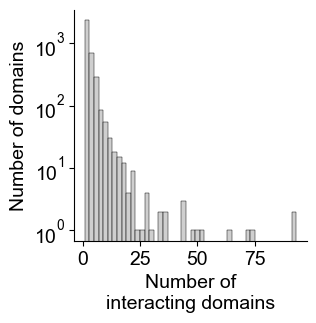

In [79]:
# Plot number of interacting domains per Pfam domain in the 3did interchain hetero protein subset

plt.figure(dpi=1200) 
fig, axes = plt.subplots(figsize=figsize)
sns.histplot(data=partner_counts, x= '# interacting domains', color = 'silver', binwidth= 2)
#axes.set_xlim(0,40) # cuts 6 outliers
plt.yscale('log')
plt.xticks(fontname="Arial", fontsize= global_fontsize)
plt.yticks(fontname="Arial", fontsize= global_fontsize)
axes.set_ylabel('Number of domains', fontsize= global_fontsize)
axes.set_xlabel('Number of\ninteracting domains', fontsize= global_fontsize)
axes.minorticks_off()
#plt.savefig(f'{save_path}no_interacting_domains_distribution_plot_3did_subset.pdf', transparent=True, bbox_inches='tight')
plt.show()